# The Open Sourcing Mental Health or OSMI Mental Health survey

## This Jupyter Notebook deals with cleaning the datasets and preparing the datasets for exploratory data analysis. It is often said that well-defined data beats fancy and complex algorithms.

### All warnings are supressed to produce more concise output.

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Importing the datasets. The datasets are from years 2014, 2016, 2017 and 2018.

In [2]:
import pandas as pd  # data processing, CSV file I/O

survey2014 = pd.read_csv('datasets/OSMIMentalHealthinTechSurvey2014.csv').assign(Year=2014)
survey2016 = pd.read_csv('datasets/OSMIMentalHealthinTechSurvey2016.csv').assign(Year=2016)
survey2017 = pd.read_csv('datasets/OSMIMentalHealthinTechSurvey2017.csv').assign(Year=2017)
survey2018 = pd.read_csv('datasets/OSMIMentalHealthinTechSurvey2018.csv').assign(Year=2018)

survey1416 =  pd.concat([survey2014, survey2016], ignore_index=True, sort=True)
survey1718 = pd.concat([survey2017, survey2018], ignore_index=True, sort=True)
survey = pd.concat([survey1416, survey1718], ignore_index=True, sort=True)
print(survey.shape)

(3866, 192)


### All the surveys have been collected and placed in a list of datasets. Now, to clean the dataset, a function is defined which takes the dataset and removes some common impurities.
#### 1. HTML elements
#### 2. Un-needed columns
#### 3. Reset index

In [3]:
import re 

def cleanColumns(dataframe):
    dataframe.columns = map(str.lower, dataframe.columns)

    # Remove HTML artifacts
    dataframe.rename(columns=lambda colname: re.sub('</\w+>', '', colname), inplace=True)
    dataframe.rename(columns=lambda colname: re.sub('<\w+>', '', colname), inplace=True)
    dataframe.rename(columns = {'how many employees does your company or organization have?':'Company Size', 
                                'do you have a family history of mental illness?' : 'Family History of Mental Illness'}, inplace = True) 
 
    dataframe.drop(columns=['#', 'start date (utc)', 'submit date (utc)', 'network id', 'timestamp'], inplace=True)
    dataframe.reset_index(drop=True)

    return dataframe

survey = cleanColumns(survey)
print(survey.shape)

(3866, 187)


### It is important to know the make up of the data and the number of null values / dirty values or noise present in it. To help with this a funtion is defined which takes the data and plots the number of null or impure values. The blue bars show missing data. Presence of large number of blue bars means the dataset is full of empty or impure values.

                                                    Total missing     Percent
mood disorder (depression, bipolar disorder, etc)            3866  100.000000
personality disorder (borderline, antisocial, p...           3866  100.000000
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
stress response syndromes                                    3866  100.000000
anxiety disorder (generalized, social, phobia, ...           3866  100.000000
post-traumatic stress disorder                               3866  100.000000
addictive disorder                                           3866  100.000000
attention deficit hyperactivity disorder                     3866  100.000000
dissociative disorder                                        3866  100.000000
substance use disorder                                       3866  100.000000
other                                                        3866  100.000000
obsessive-compulsive disorder                                386

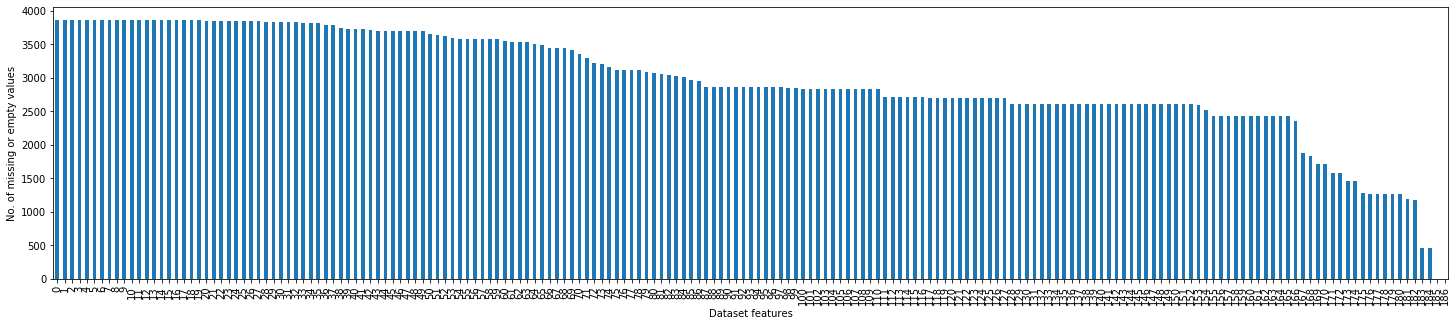

In [4]:
import numpy as np; 
import matplotlib.pyplot as plt
%matplotlib inline

def ShowNullValues(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending=False)
    nullValues = dataframe.isnull().sum()
    totalValues = dataframe.isnull().count()
    percent = (nullValues/totalValues).sort_values(ascending=False)
    missingData = pd.concat([total, percent*100], axis=1, keys=['Total missing', 'Percent'])
    print(missingData.head(20))
    plt.figure(figsize=(25,5))
    total.plot.bar()
    y = ((lambda x: str(x)) (x) for x in range(len(dataframe.columns)))
    plt.xticks(np.arange(len(dataframe.columns)), (y))
    plt.ylabel("No. of missing or empty values")
    plt.xlabel("Dataset features")
    plt.show()
    return missingData

noisyData = ShowNullValues(survey)

### Ouch! The dataset is full of missing or impure values which need to be cleaned before any further analysis can be carried out. 

### To start with, the age and gender data is cleaned.

In [5]:
# ageDistribution = survey.loc[:, survey.columns.str.contains('age', regex=True)]
ageDistribution = survey.loc[:, ['age', 'what is your age?']]
ageDistribution.fillna(0, inplace=True)
survey.loc[:,'Age'] = ageDistribution.sum(axis=1)
survey.loc[survey['Age']>100, 'Age'] = 30
survey.loc[survey['Age']<10, 'Age'] = 30
survey['Age-Group'] = pd.cut(survey['Age'], [0, 20, 30, 40, 65, 100], labels=["0-20", "21-30", "31-40", "41-65", "66-100"], include_lowest=True)
survey.drop(ageDistribution, axis=1, inplace=True)
showAge = survey['Age']
print(showAge.unique())

[37. 44. 32. 31. 33. 35. 39. 42. 23. 29. 36. 27. 46. 41. 34. 30. 40. 38.
 50. 24. 18. 28. 26. 22. 19. 25. 45. 21. 43. 56. 60. 54. 55. 48. 20. 57.
 58. 47. 62. 51. 65. 49. 53. 61. 11. 72. 52. 17. 63. 99. 66. 59. 15. 74.
 70. 64. 67.]


In [6]:
genderDistribution = survey.loc[:, survey.columns.str.contains('gender|Gender', regex=True)]
survey['Gender'] = genderDistribution.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey.loc[survey['Gender'].str.contains('Trans|them|trans|Undecided|Contextual|transgender|nb|unicorn|Unicorn|queer|NB|binary|Enby|Human|little|androgynous|Androgyne|Neutral|Agender|Androgynous|Androgynous|Fluid|GenderFluid|Genderflux|genderqueer|Genderqueer' , regex=True), 'Gender'] = 'Undecided'
survey.loc[survey['Gender'].str.contains('Female|female|FEMALE|Woman|woman|w|womail|W|Cis female| Female (cis)|Cis Female|cis female|cis woman|F|f' , regex=True), 'Gender'] = 'Female'
cond1 = survey['Gender']!='Female'
cond2 = survey['Gender']!='Undecided'
survey.loc[cond1 & cond2, 'Gender'] = 'Male'
survey.drop(genderDistribution, axis=1, inplace=True)
showGender = survey['Gender']
print(showGender.unique())

['Female' 'Male' 'Undecided']


### Number of people who have sought treatment for mental health conditions.

In [7]:
soughtTreatment = survey.loc[:, survey.columns.str.contains('sought treatment')]
soughtTreatment.fillna('', inplace=True)
survey['Sought Treatment'] = soughtTreatment.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey.loc[survey['Sought Treatment'].str.contains('yes|1.0|1|Yes' , regex=True, na=False), 'Sought Treatment'] = 1
survey.loc[survey['Sought Treatment'].str.contains('no|0.0|0|No' , regex=True, na=False), 'Sought Treatment'] = 0
survey.drop(soughtTreatment, axis=1, inplace=True)
showSoughtTreatment = survey['Sought Treatment']
print(showSoughtTreatment.unique())

[1 0]


                                                    Total missing     Percent
stress response syndromes                                    3866  100.000000
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
attention deficit hyperactivity disorder                     3866  100.000000
addictive disorder                                           3866  100.000000
anxiety disorder (generalized, social, phobia, ...           3866  100.000000
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
personality disorder (borderline, antisocial, p...           3866  100.000000
dissociative disorder                                        3866  100.000000
substance use disorder                                       3866  100.000000
eating disorder (anorexia, bulimia, etc)                     3866  100.000000
other                                                        3866  100.000000
obsessive-compulsive disorder                                386

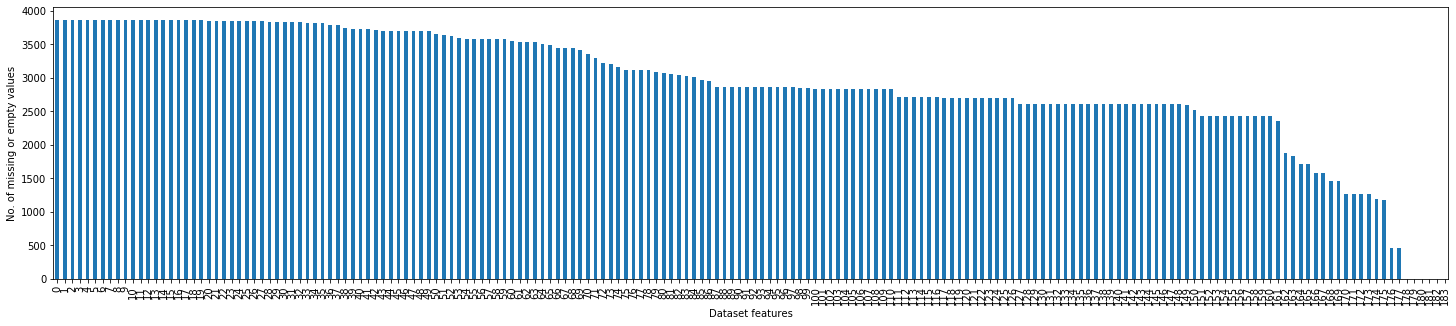

In [8]:
noisyData = ShowNullValues(survey)

### Description of prior experience with discussing about mental health.

In [9]:
describethe = survey.loc[:, survey.columns.str.contains('describe the')]
describethe.fillna('', inplace=True)
survey['Describe Past Experience'] = describethe.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey.drop(describethe, axis=1, inplace=True)
showPastExperience = survey['Describe Past Experience']
print(showPastExperience)

0                                                        
1                                                        
2                                                        
3                                                        
4                                                        
                              ...                        
3861                                                     
3862        Told about My depression got supportive re...
3863        I've brought up my depression with previou...
3864      Multiple conversations Supportive. They unde...
3865    Coworker transitioned mtf and was treated poor...
Name: Describe Past Experience, Length: 3866, dtype: object


In [10]:
anon = survey.loc[:, survey.columns.str.contains('anonymous')]
anon.fillna('', inplace=True)
survey['Prefer Anonymity'] = anon.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey.loc[survey['Prefer Anonymity'].str.contains('yes|1.0|1|Yes', regex=True, na=False), 'Prefer Anonymity'] = 1
survey.loc[survey['Prefer Anonymity'].str.contains('no|0.0|0|No' , regex=True, na=False), 'Prefer Anonymity'] = 0
survey.drop(anon, axis=1, inplace=True)
showPreferAnonymity = survey['Prefer Anonymity']
print(showPreferAnonymity.unique())

[' ' 0 1]


In [11]:
react = survey.loc[:, survey.columns.str.contains('react')]
react.fillna('', inplace=True)
survey['Rate Reaction to Problems'] = react.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey.loc[survey['Rate Reaction to Problems'].str.contains('0.0|1.0|2.0|3.0|4.0|5.0', regex=True), 'Rate Reaction to Problems'] = 'Below Average'
survey.loc[survey['Rate Reaction to Problems'].str.contains('6.0|7.0|8.0|9.0|10.0', regex=True), 'Rate Reaction to Problems'] = 'Above Average'
survey.drop(react, axis=1, inplace=True)
showReaction = survey['Rate Reaction to Problems']
print(showReaction.unique())

[' ' 'Below Average' 'Above Average']


In [12]:
neg = survey.loc[:, survey.columns.str.contains('negative|badly', regex=True)]
neg.fillna(' ', inplace=True)
survey['Negative Consequences'] = neg.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Negative Consequences'].str.contains('yes|1.0|1|Yes' , regex=True), 'Negative Consequences'] = 'Yes'
survey.loc[survey['Negative Consequences'].str.contains('maybe|Maybe|1' , regex=True), 'Negative Consequences'] = 'Maybe'
survey.loc[survey['Negative Consequences'].str.contains('no|No|0' , regex=True), 'Negative Consequences'] = 'No'
survey.loc[survey['Negative Consequences'].str.contains('self-employed' , regex=True), 'Negative Consequences'] = 'Self-Employed'
survey.drop(neg, axis=1, inplace=True)
showNegativeConsequnces = survey['Negative Consequences']
print(showNegativeConsequnces.unique())

['No' 'Maybe' 'Yes' 'Self-Employed' '             ']


### The location of people taking the OSMI tech survey.

In [13]:
work = survey.loc[:, survey.columns.str.contains('work in', regex=True)]
survey.drop(work, axis=1, inplace=True)
state = survey.loc[:, survey.columns.str.contains('country', regex=True)]
state.fillna('', inplace=True)
survey['Location'] = state.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Location'].str.contains('[A-Z][A-Z]|United States' , regex=True), 'Location'] = 'USA'
showLocation = survey['Location']
survey.drop(state, axis=1, inplace=True)
print(showLocation.unique())

['USA' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines' 'Lithuania' 'Venezuela'
 'Argentina' 'Vietnam' 'Slovakia' 'Bangladesh' 'Algeria' 'Pakistan'
 'Afghanistan' 'Other' 'Brunei' 'Iran' 'Ecuador' 'Chile' 'Guatemala'
 'Taiwan' 'Serbia' 'Estonia' 'Iceland' 'Indonesia' 'Jordan' 'Ukraine'
 'Belarus' 'Turkey' '' 'Mauritius' 'Saudi Arabia' 'Kenya' 'Ethiopia'
 'Macedonia' 'Hong Kong']


### It's important to know if the employees have access to any resources regarding mental health issues or remedies.

In [14]:
resources = survey.loc[:, survey.columns.str.contains('resources', regex=True)]
resources.fillna('', inplace=True)
survey['Access to information'] = resources.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Access to information'].str.contains('yes|Yes' , regex=True, na=False), 'Access to information'] = 1
survey.loc[survey['Access to information'].str.contains('no|No' , regex=True, na=False), 'Access to information'] = 0
survey.drop(resources, axis=1, inplace=True)
showAccessToInformation = survey['Access to information']
print(showAccessToInformation.unique())

[1 0]


                                                    Total missing     Percent
addictive disorder                                           3866  100.000000
personality disorder (borderline, antisocial, p...           3866  100.000000
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
anxiety disorder (generalized, social, phobia, ...           3866  100.000000
attention deficit hyperactivity disorder                     3866  100.000000
other                                                        3866  100.000000
stress response syndromes                                    3866  100.000000
substance use disorder                                       3866  100.000000
post-traumatic stress disorder                               3866  100.000000
obsessive-compulsive disorder                                3866  100.000000
mood disorder (depression, bipolar disorder, etc)            386

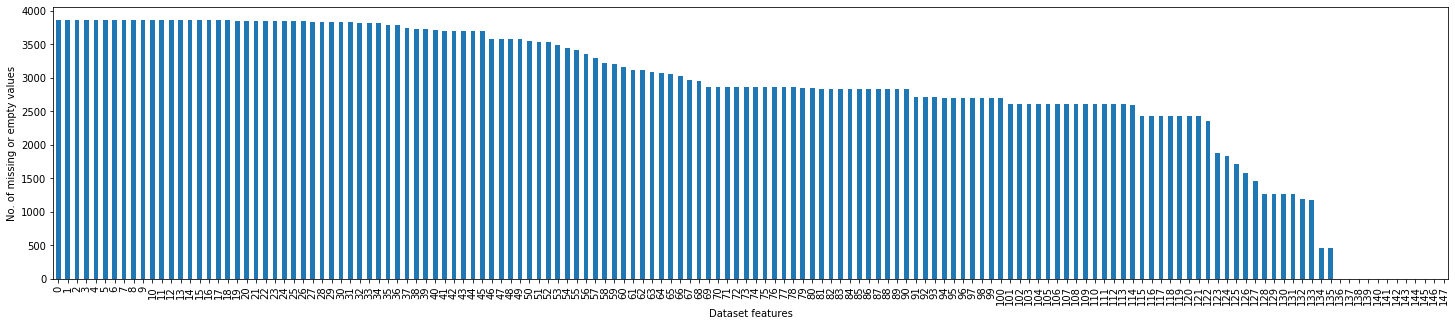

In [15]:
noisyData = ShowNullValues(survey)

### Let's explore if the employees have had any history of past diagnosis or if they find it comfortable to discuss their problems with their co-workers or supervisors.  

In [16]:
insurance = survey.loc[:, survey.columns.str.contains('insurance', regex=True)]
insurance.fillna('', inplace=True)
survey['Insurance'] = insurance.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey.loc[survey['Insurance'].str.contains('1.0|1' , regex=True, na=False), 'Insurance'] = 1
survey.loc[survey['Insurance'].str.contains('0.0|0' , regex=True, na=False), 'Insurance'] = 0
survey.drop(insurance, axis=1, inplace=True)
showInsurance = survey['Insurance']
print(showInsurance.unique())

[' ' 1 0]


In [17]:
diagnosis = survey.loc[:, survey.columns.str.contains('diagnosed|Diagnosed|diagnose|Diagnose', regex=True)]
diagnosis.fillna(' ', inplace=True)
survey['Diagnosis'] = diagnosis.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Diagnosis'].str.contains('yes|Yes' , regex=True), 'Diagnosis'] = 'Yes'
survey.loc[survey['Diagnosis'].str.contains('no|No' , regex=True), 'Diagnosis'] = 'No'
survey.loc[survey['Diagnosis'].str.contains('sometimes|Sometimes' , regex=True), 'Diagnosis'] = 'Sometimes'
survey.drop(diagnosis, axis=1, inplace=True)
showDiagnosis = survey['Diagnosis']
print(showDiagnosis.unique())

['        ' 'Yes' 'No' 'Sometimes']


In [18]:
discuss = survey.loc[:, survey.columns.str.contains('discuss|Discuss', regex=True)]
discuss.fillna('', inplace=True)
survey['Discuss Mental Health Problems'] = discuss.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Discuss Mental Health Problems'].str.contains('some|Some' , regex=True), 'Discuss Mental Health Problems'] = 'Maybe'
survey.loc[survey['Discuss Mental Health Problems'].str.contains('yes|Yes' , regex=True), 'Discuss Mental Health Problems'] = 'Yes'
survey.loc[survey['Discuss Mental Health Problems'].str.contains('no|No' , regex=True), 'Discuss Mental Health Problems'] = 'No'
survey.drop(discuss, axis=1, inplace=True)
showDiscussMentalHealthProblems = survey['Discuss Mental Health Problems']
print(showDiscussMentalHealthProblems.unique())

['Maybe' 'No' 'Yes' '']


### An employer that positively treats issues regarding mental health goes a long way in making the worlplace friendlier.

In [19]:
response = survey.loc[:, survey.columns.str.contains('handled|provided|serious', regex=True)]
response.fillna(' ', inplace=True)
survey['Responsible Employer'] = response.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Responsible Employer'].str.contains('some|Some' , regex=True), 'Responsible Employer'] = 'Maybe'
survey.loc[survey['Responsible Employer'].str.contains('yes|Yes' , regex=True), 'Responsible Employer'] = 'Yes'
survey.loc[survey['Responsible Employer'].str.contains('no|No' , regex=True), 'Responsible Employer'] = 'No'
survey.loc[survey['Responsible Employer'].str.contains('self-employed' , regex=True), 'Responsible Employer'] = 'Self-Employed'
survey.drop(response, axis=1, inplace=True)
showResposibleEmployer = survey['Responsible Employer']
print(showResposibleEmployer.unique())

['Yes' 'No' 'Maybe' '         ' 'Self-Employed']


                                                    Total missing     Percent
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
obsessive-compulsive disorder                                3866  100.000000
psychotic disorder (schizophrenia, schizoaffect...           3866  100.000000
addictive disorder                                           3866  100.000000
stress response syndromes                                    3866  100.000000
substance use disorder                                       3866  100.000000
anxiety disorder (generalized, social, phobia, ...           3866  100.000000
personality disorder (borderline, antisocial, p...           3866  100.000000
dissociative disorder                                        3866  100.000000
mood disorder (depression, bipolar disorder, etc)            3866  100.000000
eating disorder (anorexia, bulimia, etc)                     3866  100.000000
attention deficit hyperactivity disorder                     386

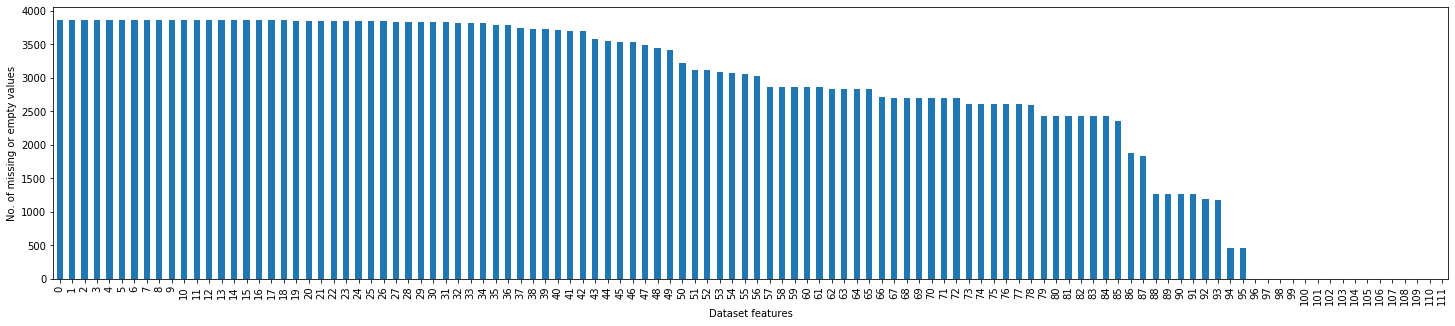

In [20]:
noisyData = ShowNullValues(survey)

### Let's check if employees or workers have any history of disorders or if they work in technology sector.

In [21]:
Disorder = survey.loc[:, survey.columns.str.contains('Disorder|disorder|syndrome|other', regex=True)]
Disorder.fillna('', inplace=True)
DisorderNotes = Disorder.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
survey['Disorder Notes'] = DisorderNotes
survey['Disorder'] = DisorderNotes
disorderTerms = 'disorder|Disorder|negative|Negative|syndrome|Syndrome|bipolar|Bipolar|depression|Depression|autism|PTSD|Yes|yes'
survey.loc[survey['Disorder'].str.contains(disorderTerms , regex=True), 'Disorder'] = 1
survey.loc[survey['Disorder']!=1, 'Disorder'] = 0
survey.drop(Disorder, axis=1, inplace=True)
showDisorder = survey[['Disorder', 'Disorder Notes']]
print(survey['Disorder'].unique())

[0 1]


In [22]:
techEmployer = survey.loc[:, survey.columns.str.contains('tech company|tech/IT', regex=True)]
techEmployer.fillna(' ', inplace=True)
survey['Tech Employer'] = techEmployer.apply(lambda row: ''.join(row.values.astype(str)), axis=1)
survey.loc[survey['Tech Employer'].str.contains('yes|Yes|1|1.0' , regex=True, na=False), 'Tech Employer'] = 1
survey.loc[survey['Tech Employer'].str.contains('no|No|0|0.0' , regex=True, na=False), 'Tech Employer'] = 0
survey.drop(techEmployer, axis=1, inplace=True)
showTechEmployer = survey['Tech Employer']
print(showTechEmployer.unique())

[1 0 '  ']


                                                    Total missing    Percent
how has it affected your career?                             3824  98.913606
has being identified as a person with a mental ...           3731  96.508019
any additional notes or comments                             3702  95.757889
if there is anything else you would like to tel...           3585  92.731505
if maybe, what condition(s) do you believe you ...           3544  91.670978
if yes, what percentage of your work time (time...           3536  91.464046
do you believe your productivity is ever affect...           3410  88.204863
does your employer provide mental health benefi...           3223  83.367822
if you live in the united states, which state o...           3122  80.755303
what is your race?                                           3082  79.720641
briefly describe what you think the industry as...           3077  79.591309
what us state or territory do you live in?                   3058  79.099845

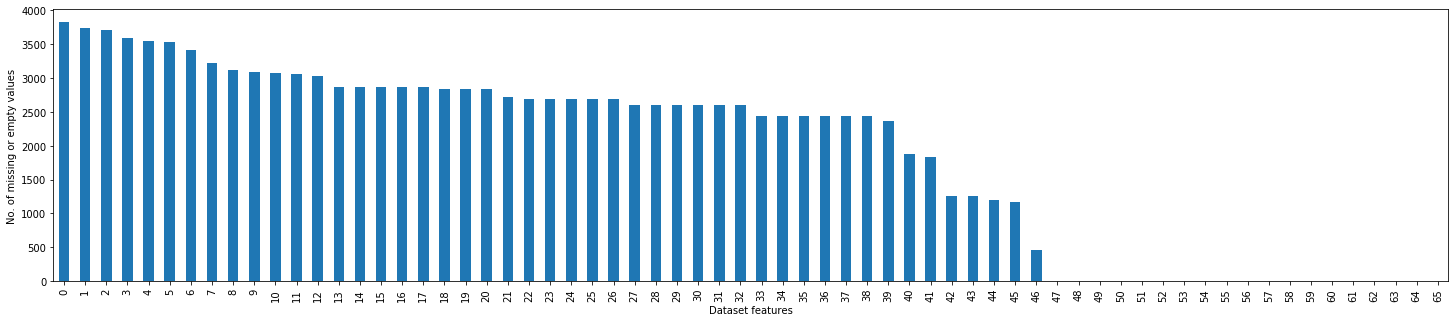

In [23]:
noisyData = ShowNullValues(survey)

### The dataset is cleaned to remove duplicate columns and the mostly empty features.

In [24]:
survey = survey.loc[:, ~survey.columns.duplicated()]
survey.replace('', np.nan, inplace=True)   


emptyColumns = survey.isnull().sum() 
for column in emptyColumns.index:
      if emptyColumns[column]>1000:
          survey.drop(column, axis=1, inplace=True)

### The features in the cleaned dataset are typecasted to their appropriate datatype. It is then exported and saved as a CSV file.

In [25]:
for feature in survey:
    try: 
        survey[feature] = pd.to_numeric(survey[feature], errors='coerce').astype(int)
        print('numeric cast\t\t', feature)
    except:
       try:
           survey[feature] = survey[feature].astype(str)
           survey.loc[survey[feature].str.contains('^\s+$|nan' , regex=True), feature] = np.nan
           print('str cast\t\t', feature)
       except:
           continue
                 
survey.to_csv('cleanedDatasets/OSMIcleaned.csv', index=False)

str cast		 Family History of Mental iIllness
str cast		 Company Size
numeric cast		 year
numeric cast		 Age
str cast		 Age-Group
str cast		 Gender
numeric cast		 Sought Treatment
str cast		 Describe Past Experience
str cast		 Prefer Anonymity
str cast		 Rate Reaction to Problems
str cast		 Negative Consequences
str cast		 Location
numeric cast		 Access to information
str cast		 Insurance
str cast		 Diagnosis
str cast		 Discuss Mental Health Problems
str cast		 Responsible Employer
str cast		 Disorder Notes
numeric cast		 Disorder
str cast		 Tech Employer


                                   Total missing    Percent
Insurance                                   3410  88.204863
Describe Past Experience                    3142  81.272633
Rate Reaction to Problems                   2695  69.710295
Prefer Anonymity                            2695  69.710295
Diagnosis                                   1822  47.128815
Disorder Notes                              1260  32.591826
Company Size                                 456  11.795137
Tech Employer                                302   7.811692
Responsible Employer                          38   0.982928
Discuss Mental Health Problems                28   0.724263
Location                                       2   0.051733
Negative Consequences                          2   0.051733
Disorder                                       0   0.000000
Access to information                          0   0.000000
Sought Treatment                               0   0.000000
Gender                                  

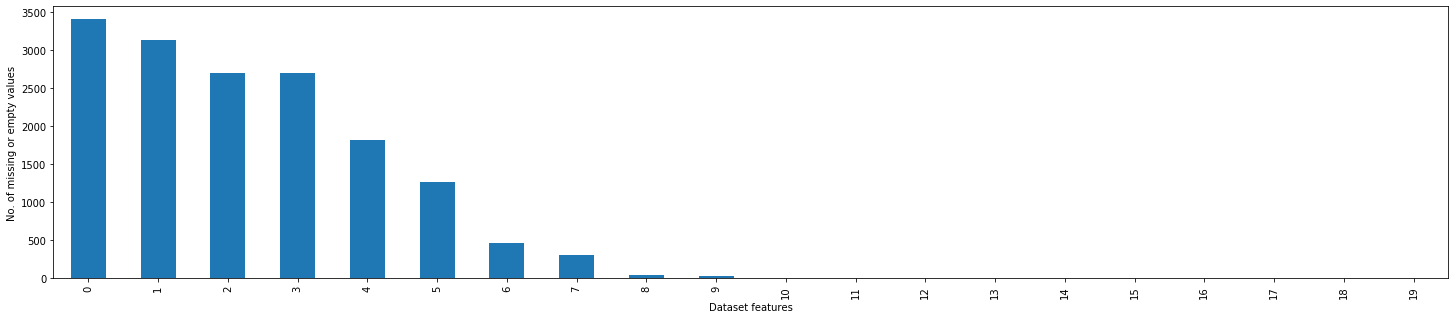

In [26]:
noisyData = ShowNullValues(survey)

In [27]:
print(survey.shape)

(3866, 20)


## The cleaned dataset, *OSMIcleaned.csv*, is in **cleanedDatasets** directory.